In [241]:
import os
import pprint
from bs4 import BeautifulSoup, NavigableString

# Functions

In [242]:
def parse_nested_braces(string):
    stack = []
    results = []
    current = []

    for char in string:
        if char == '{':
            stack.append('{')
            current.append(char)
        elif char == '}' and stack:
            stack.pop()
            current.append(char)
            if not stack:  # Completed a nested structure
                results.append(''.join(current))
                current = []
        elif stack:
            current.append(char)

    return results

In [243]:
def parse_key_value_pairs(string):
    def is_key_start(index):
        # Check if the current index is the start of a key
        return string[index] == '"' and (index == 0 or string[index - 1] not in '\\')

    def find_key_end(start_index):
        # Find the end of the key (next unescaped quote)
        index = start_index + 1
        while index < len(string):
            if string[index] == '"' and string[index - 1] != '\\':
                return index
            index += 1
        return -1

    def find_value(index):
        if string[index] in '{[':
            # Handle nested structure
            opening = string[index]
            closing = '}' if opening == '{' else ']'
            depth = 1
            index += 1
            while index < len(string) and depth > 0:
                if string[index] == opening:
                    depth += 1
                elif string[index] == closing:
                    depth -= 1
                index += 1
            return index
        else:
            # Handle simple value
            in_quotes = False
            while index < len(string):
                if string[index] == '"' and (index == 0 or string[index - 1] != '\\'):
                    in_quotes = not in_quotes
                elif not in_quotes and string[index] in ',}':
                    return index
                index += 1
            return index

    results = {}
    i = 0
    while i < len(string):
        if is_key_start(i):
            key_end = find_key_end(i)
            if key_end != -1:
                key = string[i + 1:key_end]
                # Skip to the colon and the following whitespace
                i = key_end + 2
                while i < len(string) and string[i] in ' \t':
                    i += 1
                value_end = find_value(i)
                value = string[i:value_end].strip()
                results[key] = value
                i = value_end
        i += 1

    return results

In [276]:
def parse_item(pageItem):
    if pageItem['type'] == '"TITLE"':
        new_pageItem['type'] = "TITLE"
        new_pageItem['value'] = pageItem['value']
        
    if pageItem['type'] == '"IMAGE"':
        new_pageItem['type'] = "IMAGE"
        userFile = parse_key_value_pairs(pageItem['userFile'])
        url = f"https://courses.edovo.com/{userFile['contentPath'][1:-1]}"
        new_pageItem['value'] = url

    if pageItem['type'] == '"SHORT_ANSWER"':
        new_pageItem['type'] = "SHORT_ANSWER"

        question = pageItem['value']
        question = ' '.join(BeautifulSoup(question, 'html.parser').text.replace("\n"," ").replace("\\\\\\", "").replace("\\", "").split())
        
        answers = [parse_key_value_pairs(pi) for pi in parse_nested_braces(pageItem['answers'][1:-1])]
        answers = answers[0]['answerText']
        
        html_soup = BeautifulSoup(answers, 'html.parser')

        all_text = []
        for tag in html_soup.stripped_strings:
            text = ' '.join(repr(tag).strip()[1:-1].replace("\n"," ").replace("\\\\\\", "").replace("\\", "").split())
            all_text.append(text)
        
        new_pageItem['value'] = {'question': question, 'answers': all_text}

    if pageItem['type'] == '"TEXT"':
        new_pageItem['type'] = "TEXT"
        html = pageItem['value']
        html_soup = BeautifulSoup(html, 'html.parser')

        all_text = []
        for tag in html_soup.stripped_strings:
            text = ' '.join(repr(tag).strip()[1:-1].replace("\n"," ").replace("\\\\\\", "").replace("\\", "").split())
            all_text.append(text)

        html_imgs = html_soup.find_all('img')
        html_imgs_srcs = [img['src'].replace('\\"',"") for img in html_imgs if 'src' in img.attrs]
        
        new_pageItem['value'] = {'text': all_text, 'images': html_imgs_srcs}
        
    if pageItem['type'] == '"MULTIPLE_CHOICE"':
        new_pageItem['type'] = "MULTIPLE_CHOICE"

        question = pageItem['value']
        question = ' '.join(BeautifulSoup(question, 'html.parser').text.replace("\n"," ").replace("\\\\\\", "").replace("\\", "").split())

        explanation = pageItem['explanation']
        explanation = ' '.join(BeautifulSoup(explanation, 'html.parser').text.replace("\n"," ").replace("\\\\\\", "").replace("\\", "").split())

        answers = [parse_key_value_pairs(pi) for pi in parse_nested_braces(pageItem['answers'][1:-1])] 
        answers = [(' '.join(BeautifulSoup(pi['answerText'], 'html.parser').text.replace("\n"," ").replace("\\\\\\", "").replace("\\", "").split()),pi['correct']) for pi in answers]

        new_pageItem['value'] = {'question': question, 'answers': answers, 'explanation': explanation}
        
    return new_pageItem

In [277]:
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

# Read all files

In [278]:
root_path = '/Users/vivianamarquez/Desktop/prisoneducation/raw_html/'
all_files = []

for root, dirs, files in os.walk(root_path):
    for file in files:
        file_path = os.path.join(root, file)
        if file_path.endswith('.html'):
            all_files.append(file_path)
            
all_files.sort(key=natural_sort_key)
all_files

['/Users/vivianamarquez/Desktop/prisoneducation/raw_html/lesson_1/page_1.html',
 '/Users/vivianamarquez/Desktop/prisoneducation/raw_html/lesson_1/page_2.html',
 '/Users/vivianamarquez/Desktop/prisoneducation/raw_html/lesson_1/page_3.html',
 '/Users/vivianamarquez/Desktop/prisoneducation/raw_html/lesson_1/page_4.html',
 '/Users/vivianamarquez/Desktop/prisoneducation/raw_html/lesson_2/page_1.html',
 '/Users/vivianamarquez/Desktop/prisoneducation/raw_html/lesson_2/page_2.html',
 '/Users/vivianamarquez/Desktop/prisoneducation/raw_html/lesson_3/page_1.html',
 '/Users/vivianamarquez/Desktop/prisoneducation/raw_html/lesson_3/page_2.html',
 '/Users/vivianamarquez/Desktop/prisoneducation/raw_html/lesson_3/page_3.html',
 '/Users/vivianamarquez/Desktop/prisoneducation/raw_html/lesson_3/page_4.html',
 '/Users/vivianamarquez/Desktop/prisoneducation/raw_html/lesson_3/page_5.html',
 '/Users/vivianamarquez/Desktop/prisoneducation/raw_html/lesson_3/page_6.html',
 '/Users/vivianamarquez/Desktop/prisoned

*****************************************************************************************
lesson_1
page_1
*****************************************************************************************

Item 1
{'type': 'TITLE', 'value': '"Welcome to Web Development!"'}


Item 2
{'type': 'TEXT',
 'value': {'images': ['https://speckyboy.com/wp-content/uploads/2011/05/wireframe-sketch-01.jpg'],
           'text': ['"',
                    'Welcome to Web Development!',
                    'Welcome to the world of web development! As you begin '
                    "this journey, it's perfectly fine if you're new to the "
                    'concept web development and the role of web developers. '
                    'This course is designed to teach you everything you need '
                    'for a solid start in web development, without requiring '
                    "any previous knowledge. Let's start by understanding what "
                    'web development is and how it can benefi
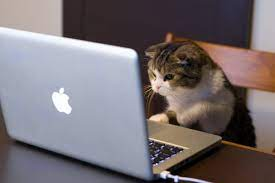


Item 1
{'type': 'TITLE', 'value': '"Conditionals Continued"'}


Item 2
{'type': 'TEXT',
 'value': {'images': ['https://www.programiz.com/sites/tutorial2program/files/python-if-else.png'],
           'text': ['"',
                    'nn',
                    'How do Conditionals Work?',
                    'As shown in the picture from the last slide, we declare a '
                    'conditional in code as so;',
                    '1: if _____ :',
                    '2: //code',
                    'nn',
                    "In this context, we're presented with two distinct "
                    'sections. Initially, we encounter line one, where an '
                    'essential construct termed an "if-statement" is declared. '
                    'Observe the intentional spacing left between the "if" '
                    'keyword and the ensuing colon. This specific juncture is '
                    'where our condition, the pivotal criterion, will be '
                    '


Item 1
{'type': 'TITLE', 'value': '"Knowledge Check"'}


Item 2
{'type': 'SHORT_ANSWER',
 'value': {'answers': ['"',
                       "@app.route('/home')",
                       'def show_home():',
                       "return render_template('home.html')",
                       '"'],
           'question': '" If this was your project structure flaskdemo1 app.py '
                       'static templates about.html hello.html home.html venv '
                       'How would you write code to a dd a route "/home" that '
                       'will display the home.html page? Hint: you will need '
                       'to add three things: the route, the function name, and '
                       'the rendered file "'}}


Item 3
{'type': 'MULTIPLE_CHOICE',
 'value': {'answers': [('" It creates new HTML templates for your website. "',
                        'false'),
                       ('" It runs Python code in your HTML templates. "',
                        'fals


Item 5
{'type': 'TEXT',
 'value': {'images': ['https://lh5.googleusercontent.com/TSX9THoLSgQY9y5OzfM_RDDtEWWtvqvsl5foVZkabp7YYcVtldnqjLrLkwjW9ctWva6Yn3HFL-_Xh6RM5KwzQzBC1oVRl-WoNWYEDChIzws0qrCX42EE6gL_Pz21yBAwFen0gzZLZgD3HUgAkkAOHMo',
                      'https://lh6.googleusercontent.com/58QFeGUJkJ8_phf4ssvFIKhPGYGbG-TO3PXye-GRLQtnfmy0KlMB07GY6U4j81L9HzGKuGh_DQSYy3P0GyUGB_WaG_MxHUm09uLbPpRiA07SAu7DMQ0MA6EeR-isveHyCJ2ciWPbJPxZkK0lNEwEmtQ',
                      'https://lh3.googleusercontent.com/-gERmpCV6G8oCJukJXYbqE0UDJsUC7i28NBp1wnBtBuyN7AwooQzXJUo6HiEWlV9M4jz_aef0Sl_pEyvg6WfrxdY48gY1bdWTNK4L4s33GKLlerRZiDZA1sGcE5G6qo5AVY6hBadpV0C4SAf5RZdsoE',
                      'https://lh6.googleusercontent.com/Aed6TatypTt7VR6g1F-8t6y7gYdlDQ8FUqnZQ214-XYvcXv3KYWCdsjjn7Qspritj5nnoOaexb_vuQ1gryHud4xJviu3GCgPpa912fRC4gOpU9ZguBcaNAoj_tG1Fv1HYqEMjT33-E1IF45QyP6-jdo'],
           'text': ['"',
                    'We know already how to make a table in pure Python, so '
                    'now le

In [280]:
for path in all_files:
    lesson = path.split("/")[-2]
    page = path.split("/")[-1].split(".")[0]
    print("*"*89)
    print(lesson)
    print(page)
    print("*"*89)
    
    with open(path, 'r') as file:
        html_content = file.read()
        
    pageItems_string = html_content.split('"pageItems":[')[1].rsplit("]", maxsplit=1)[0]
    
    pageItems = parse_nested_braces(pageItems_string)
    pageItems = [parse_key_value_pairs(pi) for pi in pageItems]
    
    for i, pageItem in enumerate(pageItems):
        pi = parse_item(pageItem)
        print()
        print(f"Item {i+1}")
        pprint.pprint(pi)
        print()
        
    print()
    